## Train the summarization method with seq2seq model ### 

This is to use the TensorLayer to implement the seq2seq model for generating text summaries.  Specifically, we generate one sentence headline for the content.  

### Prepare data, including pickle, word embedding and etc.  

Currently we only have an extremly simple example for word embedding.  
First, we will read the pickle file and then split it into a sequence of words for title and content.  Our model will use the word RNN-RNN model.  

In [2]:
import pickle
import re
import numpy as np
import tensorflow as tf
from collections import Counter

#### Write into pickle file
The following cell is to open the Wechat files and save them as a pickle file. 

In [3]:
title_file = open('data/Wechat_title.parsed.txt', encoding='utf8')
content_file = open('data/Wechat_content.parsed.txt', encoding='utf8')

title_line = title_file.readlines()
content_line = content_file.readlines()

pkl_file = open('data.pkl', 'wb')
data  = {
    'title':title_line,
    'content':content_line,
    'keyword':None
}

pickle.dump(data, pkl_file)
pkl_file.close()

#### Read data from the Pickle file and split them into a sequence of tokens separated by space.  
Each token can be a single Chinese character or tokenized word.  

In [4]:
pkl_file = open('data.pkl', 'rb')

data = pickle.load(pkl_file)

pkl_file.close()

title = data['title']
content = data['content']
#title_words = [t.split() for t in title]
#content_words = [c.split() for c in content]

#### Generate vocabulary file 
The vocabulary file contains all unique words in the corpus.  

In [5]:
from itertools import chain

def generate_vocab(lst):
    word_counter = Counter([w for curr_line in lst for w in curr_line.split() ])
    return word_counter

vocabcounter = generate_vocab(title+content)
vocabcounter = sorted(vocabcounter.items(), key=lambda d:d[1], reverse=True)
#print(sorted(vocabcounter.items(), key=lambda d:d[1], reverse=True))
#print(vocabsort)
vocab = [w[0] for w in vocabcounter ]
# print(vocab)

In [6]:
# create look up table for vocab: word2idx and idx2word
word2idx = {w:i for i, w in enumerate(vocab)}
idx2word = {i:w for i, w in enumerate(vocab)}
print(idx2word[0])
print(word2idx['可以'])

可以
0


#### Display the word frequency of the dictionary. 

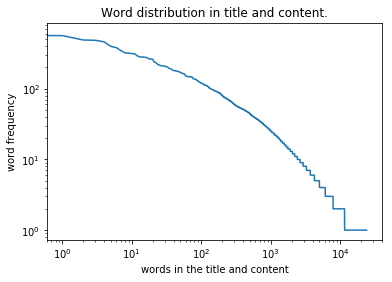

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot([w[1] for w in vocabcounter])
plt.gca().set_xscale("log", nonposx="clip")
plt.gca().set_yscale("log", nonposy="clip")
plt.title("Word distribution in title and content.")
plt.xlabel("words in the title and content")
plt.ylabel("word frequency")

### Load the word embedding file.  

In [8]:
# Code here 

def load_wordembedding(file_dir):
    
    file = open(file_dir, encoding='utf8')
    line = file.readline()
    words = []
    vectors = []
    while line:
        temp_tokens = re.split(",", line) # line.split(",")
        if len(temp_tokens) != 201:
            print("error length: %d\n"%len(temp_tokens), temp_tokens[0:3])
            line = file.readline()
            continue
        words.append(temp_tokens[0])
        vectors.append([float(x) for x in temp_tokens[1:201]])
        line = file.readline()
    return np.array(words), np.array(vectors)

In [9]:
def test_wordembedding():
    words, vectors = load_wordembedding("data/word_vector.csv")
    print(words.shape, vectors.shape)
    assert words.shape== (9846,)
    assert vectors.shape == (9846,200)

In [10]:
#code here: test the data we have so far.  
test_wordembedding()
#print(title_words[0])
#print(content_words[0])
words, vectors = load_wordembedding("data/word_vector.csv")

(9846,) (9846, 200)


Find the intersection of the given embeddings and the vocabulary.  For now, let us just simple disgard those that are not in the embedding.  There are other ways to deal with this.  We can explore them in the future. 

In [11]:
#embedding_words2idx = {w:i for i, w in enumerate(words)}
#print(words[:10])
matched_words = []
idx_vocab2idx_embedding={}
for i in range(len(words)):
    w = words[i]
    if w in vocab:
        matched_words.append(w)
        idx_vocab2idx_embedding[word2idx[w]] = i

In [12]:
print(idx_vocab2idx_embedding[0], idx2word[0], words[189])

189 可以 可以


In [13]:
import pickle
FN = 'vocabulary-embedding'
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((matched_words, vectors, idx2word, word2idx, idx_vocab2idx_embedding),fp,-1)
    

In [14]:
X = [ c.split() for c in content]
Y = [ t.split() for t in title]

with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X, Y), fp, -1)


### Data summary
For this summarization task, we need to generate a few data files for training. 

(embedding, idx2word, word2idx, glove_idx2idx)

1. embedding: (vocab_size, embedding_dim).  This is a numpy array storing all word vectors.  The order of those words are based from the input embedding files.  The order is kind of arbitrary. 
2. embedding_words: a list of words in the same order as the embedding, i.e., words[i] -> embedding[i]
3. vocab:  a list of words in the given data corpus.  
4. word2idx: dictionary to map a word to its position in the vocab
5. idx2word: dictionary to map a postion in vocab to the actual word
6. idx2idx_embedding: dictionary to map a word index in the vocab to the embedding index,i.e., word2idx[w]:embedding_words2indx[w].   This is to make it easy to find embeddings, given an index of a word. 


### Build the sequence to sequence model for summarization 
1. Initialize parameters, placeholders/network configurations/...
2. Load data 
2. Build the network in tensorlayer
3. Train the network with specific configuration

In [15]:
maxlend=25 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm=False


In [16]:
activation_rnn_size = 40 if maxlend else 0

In [17]:
# training parameters
seed=42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size=64
nflips=10

In [18]:
nb_train_samples = 200 #30000
nb_val_samples = 100 #3000

nb_unknown_words = 10 # we use the last 10 words to replace unknown words.  Actually, we can just use one for it, e.g., (的/了)

The input data is concatenated from the content and the title.  The length is defined as maxlend and maxlent respectively.  In other words, the first half of the input comes from the content and the second half comes from the title.  If the source data is shorter than the required one, we add empty strings.  If longer, we cut off the tail. 

The label data(sequence) is just the title. 

In [19]:
# load data from pickle file 
import pickle
FN = 'vocabulary-embedding'
with open('data/%s.pkl'%FN, 'rb') as fp:
    matched_words_, vectors, idx2word, word2idx, idx_vocab2idx_embedding = pickle.load(fp)
    
vocab_size, embedding_size = vectors.shape

with open('data/%s.data.pkl'%FN, 'rb') as fp:
    X, Y = pickle.load(fp)
tf.global_variables_initializer
print(vocab_size, embedding_size, len(X), len(Y))

9846 200 300 300


In [20]:
print ('number of examples:',len(X),len(Y))
print ('dimension of embedding space for words:',embedding_size)
print ('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print ('total number of different words',len(idx2word), len(word2idx))
print ('number of words outside vocabulary which we can substitue using glove similarity', len(idx_vocab2idx_embedding))
print ('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(idx_vocab2idx_embedding))

number of examples: 300 300
dimension of embedding space for words: 200
vocabulary size 9846 the last 10 words can be used as place holders for unknown/oov words
total number of different words 23992 23992
number of words outside vocabulary which we can substitue using glove similarity 4300
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 9846


In [21]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)
#print(X_train[:3])
#print(Y_train[:3])

(200, 200, 100, 100)

The input to the whole network is a sequence of words, the output is another sequence of words, which are the generated title of the given input.  The input has a fixed windows size, 

In [22]:
x = tf.placeholder(tf.float32, shape=(batch_size, embedding_size))